<div align="center">
	<br>
	<br>
  	<a href="http://mosig.imag.fr/">
		<img src="uga.jpg" width="400">
	</a>
    <h1><b>BlackJack AI</b></h1>
    <h4><i>reinforcement learning model who learned to play blackJack.</i></h4>

</div>

---


# <b>1. Introduction</b>

In this notebook we will make an AI to play the best move at the blackjack game
<br>
This game is hard to predict cause the casino always win, but we can try to found the move who maximise the profit.


# <b>2. Overview of our models</b>

## <b>2.0 Imports</b>

In [90]:
import math
import random
import gym
import numpy as np


## <b>2.1 Make the environnement </b>

We make our environment thanks to gym

it represent the bank's card by is value (from 1 to 10), and the player's card by the sum of all his cards (from 2 to 30)


In [91]:
env = gym.make('Blackjack-v1')

## <b>2.2 Utils functions</b>

Here we need two function to help the model

First, we need to initialize our QTable with 0 everywhere. We put all the values greater than 21 at the end, cause they represent the same things, the player have burst
The we need to convert the value of the result given by the environnement, to the index in the table


In [92]:
def init_q_table():
    """
    usage : q_table[_bank_cards][_player_card][action]
    :return: a new q_table with value equal to 0.0
    """
    return [[[0.0 for _ in range(2)] for _ in range(21)] for _ in range(10)]


def get_card(_env):
    _player_card, _bank_cards, _ = _env
    _player_card = min(_player_card - 2, 19)
    _bank_cards -= 1
    return _player_card, _bank_cards

## <b>2.3 Modelisation of the player</b>

We create a player, who will represent in fact our AI

It have multiples parameters:
   * His money, we start at 0 and suppose that it can decrease infinitely.
   * The environnement to be able to see the drawn card.
   * The number of games that have been played.
   * The qtable, to get his supposed optimized choice.
   * Some hyperparameters to control the target the optimal QTable.


In [119]:
class Player:
    def __init__(self, env, max_episodes):
        #Player attributes
        self.money = 0
        self.env = env
        self.nb_episode = 0
        #IA attributes
        self.q_table = init_q_table()
        #Hyperparameters
        self.max_episodes = max_episodes
        self.alphaF = self._set_alpha(10**-3)
        self.alpha = 0.2
        self.gamma = 0.6
        self.pInit = 0.6
        self.pTarget = 0.1
        self.epsilon = 0


    def epsilon_greedy_policy(self, _bank_cards, _player_card):
        """
            :param _bank_cards: the value of the bank's card
            :param _player_card: the sum of the player's cards
            :return: a random value with a probability of epsilon, the best action (according to the q_table) with a probability of 1-epsilon
        """
        if random.random() < self.epsilon:
            return random.randint(0,1)
        actions = self.q_table[_bank_cards][min(_player_card,21)]
        new_action = np.argmax(actions)
        return new_action

    def _set_alpha(self, target_final_alpha):
        '''
            :param target_final_alpha: The value of alpha that we want at the last episode, generaly arround 10**-3
            :return: the value x that solve $x^{max_episodes} = target_final_alpha$
        '''
        return math.exp(math.log(target_final_alpha) / self.max_episodes)

    def update_hyperparameter(self):
        """
            Update the hyperparameters according to the number of episodes that have been done
        """
        self.alpha = self.alphaF ** self.nb_episode
        r = (self.max_episodes - self.nb_episode) / self.max_episodes
        self.epsilon = (self.pInit - self.pTarget) * r + self.pTarget

    def step(self):
        """
            Step of the new game, it need several step
                - First we need to reset the environment
                - Then we have to select a new action thanks to our policy
                - Make the move according to the action
                - Add in the history the play
                - If the game is not finish we continue
                - Otherwise we observe the reward and update the QTable, thanks to the history
        """
        histo = []
        _player_card, _bank_cards = get_card(env.reset())
        while 1:
            #St / At+1
            _new_action = self.epsilon_greedy_policy(_bank_cards, _player_card)
            _new_state, _reward, _done, _ = env.step(_new_action)
            #St+1 / At+1
            _new_player_cards, _ = get_card(_new_state)
            histo.append((_player_card, _new_action))
            if _done :
                self.money += _reward
                for player_card, action in reversed(histo):
                    reward = self.gamma * _reward
                    self.q_table[_bank_cards][player_card][action] +=  self.alpha * (reward - self.q_table[_bank_cards][player_card][action])
                break
            _player_card = _new_player_cards




# <b>3 Training</b>

Now we want to train it
To do that we simulate a T steps

In [94]:
def train(player):
    for _ in range(player.max_episodes):
        player.nb_episode += 1
        player.update_hyperparameter()
        player.step()
    return player

# <b>4 Validation</b>

Now we want to be sure that the player have train correctly, to do that we first reset his parameters, and set epsilon to 0 ( to avoid randomness )
Then we simulate n steps and we save the money that the player won

It return the amount of money that the player have at each steps


In [95]:

def validation(player, n, bet=10) :
    """
    :param player: The player we want to evaluate
    :param n: the number of epoch
    :param bet: the amount of money that the player want to bet
    :return: For each step the reward and the total amount of money that the player have, since gym return a value in {-1,0,1} we multiply the reward by 10 to be more realistic
    """
    histo = []
    player.epsilon = 0
    player.money = 0
    rewards = []
    while n:
        n -= 1
        done = False
        carte_joueur, _bank_cards = get_card(env.reset())
        reward = 0
        while not done :
            new_action = player.epsilon_greedy_policy(_bank_cards, carte_joueur)
            new_state, reward, done, _ = env.step(new_action)
            carte_joueur, _ = get_card(new_state)
            reward *= bet
            player.money += reward
        histo.append(player.money)
        rewards.append(reward)
    return histo, rewards



# <b>5 Results and analysis</b>

We chose to train the player on 10000 iterations

The validation's number of epoch should be small, since the bank have a greater probability to win than the player, even if we maximise the gain expectation, il will be a negative value


In [183]:
import matplotlib.pyplot as plt

T=10000
bet=10

p = Player(env, T)
p = train(p)
histo, rewards = validation(p, 250, bet=bet)


We can plot the evolution of the bankroll of the player
as we can see the AI have some profit at the beginning but quickly tend to a negative profit.
This is due to the fact that in this game the bank's expectation of profit is greater than that the player's one

The player win almost 0.36$ at each steps


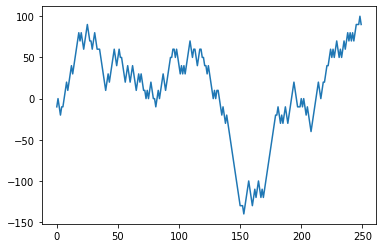

In [184]:
plt.plot(histo)
print(f"The player win almost {np.mean(rewards)}$ at each steps")